In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
# 1) Business economics (use your numbers). This is based on the analysis we did from the actual data
# https://docs.google.com/spreadsheets/d/1h8aJ9D2GGHHIpVfqhaeqhj6wQP5Wfhctptr2q7h64RI/edit?gid=788002153#gid=788002153
# This will be used for model training later.
revenue_per_good = 14250.0     # avg profit from a non-defaulted loan
loss_per_default = 90000.0 #101000.0    # assumed ~70% LGD on $144K

In [3]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the credit risk dataset
    """
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path)
    
    print(f"Original dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Remove LoanID as it's just an identifier
    if 'LoanID' in df.columns:
        df = df.drop('LoanID', axis=1)
    
    # Handle missing values
    print(f"Missing values per column:")
    print(df.isnull().sum())
    
    # Fill missing values (you may need to adjust this based on your data)
    df = df.fillna(df.median(numeric_only=True))  # Fill numeric columns with median
    df = df.fillna(df.mode().iloc[0])  # Fill categorical columns with mode
    
    # Separate features and target
    X = df.drop('Default', axis=1)
    y = df['Default']
    
    # Encode categorical variables
    categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 
                          'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
    
    # Create label encoders for categorical variables
    label_encoders = {}
    for col in categorical_columns:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
    
    # Ensure all columns are numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    
    print(f"Processed features shape: {X.shape}")
    print(f"Feature names: {list(X.columns)}")
    print(f"Default rate: {np.mean(y):.1%}")
    
    return X, y, list(X.columns), df, label_encoders



In [4]:
def prepare_data_for_models(X, y, test_size=0.2, random_state=42):
    """
    Prepare data for both monolithic and meta-learning models
    """
    # Calculate class weights to handle imbalanced data
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y),
        y=y
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    print(f"\nClass Distribution:")
    print(f"   Class 0 (No Default): {np.sum(y == 0):,} samples ({np.sum(y == 0)/len(y)*100:.1f}%)")
    print(f"   Class 1 (Default): {np.sum(y == 1):,} samples ({np.sum(y == 1)/len(y)*100:.1f}%)")
    print(f"   Imbalance Ratio: {np.sum(y == 0)/np.sum(y == 1):.1f}:1")
    print(f"\nComputed Class Weights:")
    print(f"   Class 0 weight: {class_weight_dict[0]:.3f}")
    print(f"   Class 1 weight: {class_weight_dict[1]:.3f}")
    print(f"   This gives {class_weight_dict[1]/class_weight_dict[0]:.1f}x more importance to defaults")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # For meta-learning model, we need to split features into two groups
    # Financial features: Age, Income, LoanAmount, CreditScore, MonthsEmployed, DTIRatio, InterestRate, LoanTerm
    # Behavioral features: NumCreditLines, Education, EmploymentType, MaritalStatus, HasMortgage, HasDependents, LoanPurpose, HasCoSigner
    
    feature_names = list(X.columns)
    financial_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 
                         'MonthsEmployed', 'DTIRatio', 'InterestRate', 'LoanTerm','NumCreditLines','HasMortgage']
    behavioral_features = ['Education', 'EmploymentType', 
                          'MaritalStatus', 'HasDependents', 
                          'LoanPurpose', 'HasCoSigner']
    
    # Get indices for each feature group
    financial_indices = [i for i, name in enumerate(feature_names) if name in financial_features]
    behavioral_indices = [i for i, name in enumerate(feature_names) if name in behavioral_features]
    
    print(f"Financial features ({len(financial_indices)}): {[feature_names[i] for i in financial_indices]}")
    print(f"Behavioral features ({len(behavioral_indices)}): {[feature_names[i] for i in behavioral_indices]}")
    
    # Prepare data for monolithic model
    monolithic_data = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }
    
    # Prepare data for meta-learning model
    meta_data = {
        'X_train': [X_train_scaled[:, financial_indices], X_train_scaled[:, behavioral_indices]],
        'X_test': [X_test_scaled[:, financial_indices], X_test_scaled[:, behavioral_indices]],
        'y_train': y_train,
        'y_test': y_test
    }
    
    return {
        'monolithic': monolithic_data,
        'meta_learning': meta_data,
        'scaler': scaler,
        'feature_names': feature_names,
        'financial_indices': financial_indices,
        'behavioral_indices': behavioral_indices,
        'class_weights': class_weight_dict
    }



In [5]:
def create_monolithic_model(input_dim):
    """
    Create a monolithic neural network model
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model



In [6]:
def find_optimal_threshold(y_true, y_prob, revenue_per_good, loss_per_default):
    grid = []
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).ravel()

    for t in np.linspace(0.05, 0.95, 19):
        y_hat = (y_prob >= t).astype(int)

        # Confusion matrix components
        tn = int(np.sum((y_true == 0) & (y_hat == 0)))
        fp = int(np.sum((y_true == 0) & (y_hat == 1)))
        fn = int(np.sum((y_true == 1) & (y_hat == 0)))
        tp = int(np.sum((y_true == 1) & (y_hat == 1)))

        # Metrics
        prec = float(precision_score(y_true, y_hat, zero_division=0))
        rec  = float(recall_score(y_true, y_hat, zero_division=0))
        f1   = float(f1_score(y_true, y_hat, zero_division=0))
        acc  = float((tn + tp) / max(tn + fp + fn + tp, 1))  # avoid div-by-zero

        # Business objective (approve if predicted 0, decline if predicted 1)
        # Earn revenue on approved good loans (tn), lose on approved bad loans (fn)
        profit = float(tn * revenue_per_good - fn * loss_per_default)
        #Option A1 — Add FP opportunity cost (lost revenue if you decline a good loan)
        # >>>> !!!This still does not work!!!! <<<<<<
        #profit = tn * revenue_per_good - fn * loss_per_default - fp * revenue_per_good

        grid.append({
            "threshold": float(t),
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "accuracy": acc,          # <-- added
            "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            "false_alarms": fp,       # <-- added (your plot uses this)
            "profit": profit
        })

    best = max(grid, key=lambda r: r["profit"])
    ### Put a recall floor on defaults (business guardrail)
    ### >>>!!!! Didn't work !!!!!<<<
#    r_min = 0.55  # for example
#    candidates = [r for r in grid if r["recall"] >= r_min]
#    best = max(candidates, key=lambda r: r["profit"]) if candidates else max(grid, key=lambda r: r["profit"])    
    return best, grid

In [7]:
def find_optimal_threshold2(
    y_true, y_prob, revenue_per_good, loss_per_default,
    recall_floor=None,           # e.g., 0.55 (catch >=55% of defaulters)
    grid_kind="quantile",        # "quantile" or "linear"
    n_points=31
):
    import numpy as np
    from sklearn.metrics import precision_score, recall_score, f1_score

    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).ravel()

    # Build a grid that actually covers where your scores live
    if grid_kind == "quantile":
        lo, hi = np.quantile(y_prob, [0.05, 0.995])
        thresholds = np.linspace(lo, hi, n_points)
    else:
        thresholds = np.linspace(0.05, 0.95, n_points)

    grid = []
    for t in thresholds:
        y_hat = (y_prob >= t).astype(int)  # 1 = decline, 0 = approve

        tn = int(np.sum((y_true==0) & (y_hat==0)))  # approved good loans
        fp = int(np.sum((y_true==0) & (y_hat==1)))  # declined good (lost revenue)
        fn = int(np.sum((y_true==1) & (y_hat==0)))  # approved defaults (losses)
        tp = int(np.sum((y_true==1) & (y_hat==1)))  # declined defaults (avoid loss)

        prec = float(precision_score(y_true, y_hat, zero_division=0))
        rec  = float(recall_score(y_true, y_hat, zero_division=0))
        f1   = float(f1_score(y_true, y_hat, zero_division=0))
        acc  = float((tn+tp) / (tn+fp+fn+tp))

        # Profit: earn on approved good (tn), lose on approved bad (fn),
        # and CHARGE opportunity cost for declining a good loan (fp).
        profit = float(tn*revenue_per_good - fn*loss_per_default - fp*revenue_per_good)

        grid.append({
            "threshold": float(t),
            "precision": prec, "recall": rec, "f1": f1, "accuracy": acc,
            "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            "false_alarms": fp, "profit": profit
        })

    candidates = grid
    if recall_floor is not None:
        feas = [r for r in grid if r["recall"] >= recall_floor]
        if feas:
            candidates = feas

    best = max(candidates, key=lambda r: r["profit"]) if candidates else max(grid, key=lambda r: r["profit"])
    return best, grid

In [8]:
def create_meta_learning_model(financial_dim, behavioral_dim):
    """
    Create a meta-learning model with specialized base models
    """
    # Base model 1: Financial features
    financial_input = Input(shape=(financial_dim,), name='financial_input')
    x1 = Dense(64, activation='relu')(financial_input)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(32, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    financial_output = Dense(16, activation='relu', name='financial_features')(x1)
    
    # Base model 2: Behavioral features
    behavioral_input = Input(shape=(behavioral_dim,), name='behavioral_input')
    x2 = Dense(64, activation='relu')(behavioral_input)
    x2 = Dropout(0.3)(x2)
    x2 = Dense(32, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    behavioral_output = Dense(16, activation='relu', name='behavioral_features')(x2)
    
    # Meta-model: Combines outputs from both base models
    combined = Concatenate(name='feature_fusion')([financial_output, behavioral_output])
    # z = Dense(32, activation='relu')(combined)
    # z = Dropout(0.3)(z)
    # z = Dense(16, activation='relu')(z)
    # z = Dropout(0.2)(z)
    # final_output = Dense(1, activation='sigmoid', name='risk_prediction')(z)
    final_output = Dense(1, activation='sigmoid', name='risk_prediction')(combined)
    
    meta_model = Model(
        inputs=[financial_input, behavioral_input],
        outputs=final_output,
        name='meta_learning_model'
    )
    
    meta_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return meta_model



In [9]:
def train_and_evaluate_models(file_path):
    """
    Train and evaluate both models on the real credit risk dataset
    """
    print("=" * 60)
    print("MONOLITHIC vs META-LEARNING MODEL COMPARISON")
    print("=" * 60)
    
    # Load and preprocess dataset
    print("\n1. Loading and preprocessing credit risk dataset...")
    X, y, feature_names, df, label_encoders = load_and_preprocess_data(file_path)
    data = prepare_data_for_models(X, y, test_size=0.2)
    
    print(f"   Dataset size: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"   Default rate: {np.mean(y):.1%}")
    print(f"   Train/Test split: {len(data['monolithic']['y_train'])}/{len(data['monolithic']['y_test'])}")
    
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    print("\n2. Training Monolithic Model (with class weights)...")
    print("-" * 40)
    
    # Train monolithic model
    input_dim = X.shape[1]
    monolithic_model = create_monolithic_model(input_dim)
    mono_history = monolithic_model.fit(
        data['monolithic']['X_train'],
        data['monolithic']['y_train'],
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        class_weight=data['class_weights'],  # Add class weights here
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate monolithic model
    mono_train_results = monolithic_model.evaluate(
        data['monolithic']['X_train'], 
        data['monolithic']['y_train'], 
        verbose=0
    )
    mono_test_results = monolithic_model.evaluate(
        data['monolithic']['X_test'], 
        data['monolithic']['y_test'], 
        verbose=0
    )
    
    print("\n3. Training Meta-Learning Model (with class weights)...")
    print("-" * 40)
    
    # Train meta-learning model
    financial_dim = len(data['financial_indices'])
    behavioral_dim = len(data['behavioral_indices'])
    meta_model = create_meta_learning_model(financial_dim, behavioral_dim)

    # Generate predictions for detailed analysis
    mono_pred = monolithic_model.predict(data['monolithic']['X_test'], verbose=0)
    meta_pred = meta_model.predict(data['meta_learning']['X_test'], verbose=0)

    # Run threshold sweep for both models (to increase precision and reduce loss/false positives)
#    best_mono, mono_grid = find_optimal_threshold(
#        data['monolithic']['y_test'].values, mono_pred.ravel(),
#        revenue_per_good, loss_per_default
#    )
#    best_meta, meta_grid = find_optimal_threshold(
#        data['meta_learning']['y_test'].values, meta_pred.ravel(),
#        revenue_per_good, loss_per_default
#    )

    best_mono, mono_grid = find_optimal_threshold2(
        data['monolithic']['y_test'].values, mono_pred,
        revenue_per_good=16250.0, loss_per_default=101000.0,
        recall_floor=0.55, grid_kind="quantile"
    )
    best_meta, meta_grid = find_optimal_threshold2(
        data['meta_learning']['y_test'].values, meta_pred,
        revenue_per_good=16250.0, loss_per_default=101000.0,
        recall_floor=0.55, grid_kind="quantile"
    )    
    meta_history = meta_model.fit(
        data['meta_learning']['X_train'],
        data['meta_learning']['y_train'],
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        class_weight=data['class_weights'],  # Add class weights here
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate meta-learning model
    meta_train_results = meta_model.evaluate(
        data['meta_learning']['X_train'], 
        data['meta_learning']['y_train'], 
        verbose=0
    )
    meta_test_results = meta_model.evaluate(
        data['meta_learning']['X_test'], 
        data['meta_learning']['y_test'], 
        verbose=0
    )
    
    print("\n4. RESULTS COMPARISON")
    print("=" * 60)
    
    # Print results
    metrics = ['Loss', 'Accuracy', 'Precision', 'Recall']
    
    print(f"{'Model':<20} {'Dataset':<10} {'Loss':<8} {'Accuracy':<10} {'Precision':<10} {'Recall':<8}")
    print("-" * 70)
    print(f"{'Monolithic':<20} {'Train':<10} {mono_train_results[0]:<8.4f} {mono_train_results[1]:<10.4f} {mono_train_results[2]:<10.4f} {mono_train_results[3]:<8.4f}")
    print(f"{'Monolithic':<20} {'Test':<10} {mono_test_results[0]:<8.4f} {mono_test_results[1]:<10.4f} {mono_test_results[2]:<10.4f} {mono_test_results[3]:<8.4f}")
    print(f"{'Meta-Learning':<20} {'Train':<10} {meta_train_results[0]:<8.4f} {meta_train_results[1]:<10.4f} {meta_train_results[2]:<10.4f} {meta_train_results[3]:<8.4f}")
    print(f"{'Meta-Learning':<20} {'Test':<10} {meta_test_results[0]:<8.4f} {meta_test_results[1]:<10.4f} {meta_test_results[2]:<10.4f} {meta_test_results[3]:<8.4f}")
    
    # Calculate improvement
    accuracy_improvement = (meta_test_results[1] - mono_test_results[1]) * 100
    precision_improvement = (meta_test_results[2] - mono_test_results[2]) * 100
    recall_improvement = (meta_test_results[3] - mono_test_results[3]) * 100
    
    print(f"\n5. META-LEARNING IMPROVEMENTS:")
    print(f"   Test Accuracy: {accuracy_improvement:+.2f} percentage points")
    print(f"   Test Precision: {precision_improvement:+.2f} percentage points")
    print(f"   Test Recall: {recall_improvement:+.2f} percentage points")
    
    # Show the impact of class weighting
    print(f"\n   CLASS WEIGHTING IMPACT:")
    print(f"   Monolithic Recall: {mono_test_results[3]*100:.1f}% (catches {mono_test_results[3]*100:.1f}% of defaults)")
    print(f"   Meta-Learning Recall: {meta_test_results[3]*100:.1f}% (catches {meta_test_results[3]*100:.1f}% of defaults)")
        
    # 4) Wire into your plotting variables (replaces placeholders you referenced)
    threshold_results = meta_grid                 # or choose mono_grid; plot whichever model you want
    business_optimal = best_meta                  # keep consistent with threshold_results

    print("\nBusiness-optimal thresholds:")
    print("  Monolithic:", best_mono)
    print("  Meta-Learning:", best_meta)
    
    # 3) Use the best thresholds for your final binary predictions & reports
#    mono_pred_binary = (mono_pred > 0.5).astype(int)
#    meta_pred_binary = (meta_pred > 0.5).astype(int)
    mono_pred_binary = (mono_pred >= best_mono["threshold"]).astype(int)
    meta_pred_binary = (meta_pred >= best_meta["threshold"]).astype(int)
    
    print(f"\n6. DETAILED CLASSIFICATION REPORTS:")
    print("\nMonolithic Model:")
    print(classification_report(data['monolithic']['y_test'], mono_pred_binary))
    
    print("\nMeta-Learning Model:")
    print(classification_report(data['meta_learning']['y_test'], meta_pred_binary))
    
    # Plot training histories and threshold analysis
    plt.figure(figsize=(20, 10))
    
    # Training history plots
    plt.subplot(2, 4, 1)
    plt.plot(mono_history.history['accuracy'], label='Monolithic Train')
    plt.plot(mono_history.history['val_accuracy'], label='Monolithic Val')
    plt.plot(meta_history.history['accuracy'], label='Meta-Learning Train')
    plt.plot(meta_history.history['val_accuracy'], label='Meta-Learning Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 4, 2)
    plt.plot(mono_history.history['loss'], label='Monolithic Train')
    plt.plot(mono_history.history['val_loss'], label='Monolithic Val')
    plt.plot(meta_history.history['loss'], label='Meta-Learning Train')
    plt.plot(meta_history.history['val_loss'], label='Meta-Learning Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 4, 3)
    plt.hist(mono_pred, alpha=0.7, label='Monolithic', bins=20)
    plt.hist(meta_pred, alpha=0.7, label='Meta-Learning', bins=20)
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    # Threshold analysis plots
    thresholds_plot = [r['threshold'] for r in threshold_results]
    accuracies = [r['accuracy'] for r in threshold_results]
    precisions = [r['precision'] for r in threshold_results]
    recalls = [r['recall'] for r in threshold_results]
    f1_scores = [r['f1'] for r in threshold_results]
    false_alarms = [r['false_alarms'] for r in threshold_results]
    
    plt.subplot(2, 4, 4)
    plt.plot(thresholds_plot, accuracies, 'o-', label='Accuracy')
    plt.plot(thresholds_plot, precisions, 's-', label='Precision')
    plt.plot(thresholds_plot, recalls, '^-', label='Recall')
    plt.plot(thresholds_plot, f1_scores, 'd-', label='F1-Score')
    plt.axvline(x=business_optimal['threshold'], color='red', linestyle='--', alpha=0.7, label='Business Optimal')
    plt.title('Metrics vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 4, 5)
    plt.plot(thresholds_plot, false_alarms, 'ro-')
    plt.axvline(x=business_optimal['threshold'], color='red', linestyle='--', alpha=0.7, label='Business Optimal')
    plt.title('False Alarms vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Number of False Alarms')
    plt.legend()
    plt.grid(True)
    
    # Precision-Recall tradeoff
    plt.subplot(2, 4, 6)
    plt.plot(recalls, precisions, 'bo-')
    for i, thresh in enumerate(thresholds_plot):
        plt.annotate(f'{thresh:.1f}', (recalls[i], precisions[i]), 
                    textcoords="offset points", xytext=(5,5), ha='left')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Tradeoff')
    plt.grid(True)
    
    # ROC-like curve showing recall vs false alarm rate
    plt.subplot(2, 4, 7)
    total_negatives = np.sum(data['meta_learning']['y_test'] == 0)
    false_alarm_rates = [fa / total_negatives for fa in false_alarms]
    plt.plot(false_alarm_rates, recalls, 'go-')
    for i, thresh in enumerate(thresholds_plot):
        plt.annotate(f'{thresh:.1f}', (false_alarm_rates[i], recalls[i]), 
                    textcoords="offset points", xytext=(5,5), ha='left')
    plt.xlabel('False Alarm Rate')
    plt.ylabel('Recall (True Positive Rate)')
    plt.title('Recall vs False Alarm Rate')
    plt.grid(True)
    
    # Business impact visualization
    plt.subplot(2, 4, 8)
    total_defaults = np.sum(data['meta_learning']['y_test'] == 1)
    caught_defaults = [recall * total_defaults for recall in recalls]
    missed_defaults = [total_defaults - caught for caught in caught_defaults]
    
    plt.bar(range(len(thresholds_plot)), caught_defaults, alpha=0.7, label='Caught Defaults', color='green')
    plt.bar(range(len(thresholds_plot)), missed_defaults, bottom=caught_defaults, alpha=0.7, label='Missed Defaults', color='red')
    plt.axvline(x=thresholds_plot.index(business_optimal['threshold']), color='blue', linestyle='--', alpha=0.7, label='Business Optimal')
    plt.xlabel('Threshold Index')
    plt.ylabel('Number of Defaults')
    plt.title('Defaults: Caught vs Missed')
    plt.xticks(range(len(thresholds_plot)), [f'{t:.1f}' for t in thresholds_plot])
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'monolithic_model': monolithic_model,
        'meta_model': meta_model,
        'data': data,
        'results': {
            'monolithic': {'train': mono_train_results, 'test': mono_test_results},
            'meta_learning': {'train': meta_train_results, 'test': meta_test_results}
        },
        'feature_info': {
            'feature_names': feature_names,
            'financial_features': [feature_names[i] for i in data['financial_indices']],
            'behavioral_features': [feature_names[i] for i in data['behavioral_indices']]
        }
    }

MONOLITHIC vs META-LEARNING MODEL COMPARISON

1. Loading and preprocessing credit risk dataset...
Loading data from: /Users/peekay/Downloads/Loan_default.csv
Original dataset shape: (255347, 18)
Columns: ['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']
Missing values per column:
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64
Processed features shape: (255347, 16)
Feature names: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm

/Users/peekay/projects/AI/meta_learning/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2554/2554 ━━━━━━━━━━━━━━━━━━━━ 2s 646us/step - accuracy: 0.6614 - loss: 0.6118 - precision: 0.2081 - recall: 0.6783 - val_accuracy: 0.7052 - val_loss: 0.5544 - val_precision: 0.2249 - val_recall: 0.6480
Epoch 2/100
2554/2554 ━━━━━━━━━━━━━━━━━━━━ 2s 648us/step - accuracy: 0.6724 - loss: 0.6010 - precision: 0.2162 - recall: 0.6886 - val_accuracy: 0.6955 - val_loss: 0.5609 - val_precision: 0.2221 - val_recall: 0.6675
Epoch 3/100
2554/2554 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.6793 - loss: 0.5995 - precision: 0.2196 - recall: 0.6854 - val_accuracy: 0.6753 - val_loss: 0.6023 - val_precision: 0.2147 - val_recall: 0.6950
Epoch 4/100
2554/2554 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - accuracy: 0.6807 - loss: 0.5976 - precision: 0.2207 - recall: 0.6864 - val_accuracy: 0.6922 - val_loss: 0.5526 - val_precision: 0.2209 - val_recall: 0.6725
Epoch 5/100
2554/2554 ━━━━━━━━━━━━━━━━━━━━ 2s 645us/step - accuracy: 0.6806 - loss: 0.5968 - precision: 0.2206 - recall: 0.6863 - val_accuracy: 0.6631 -

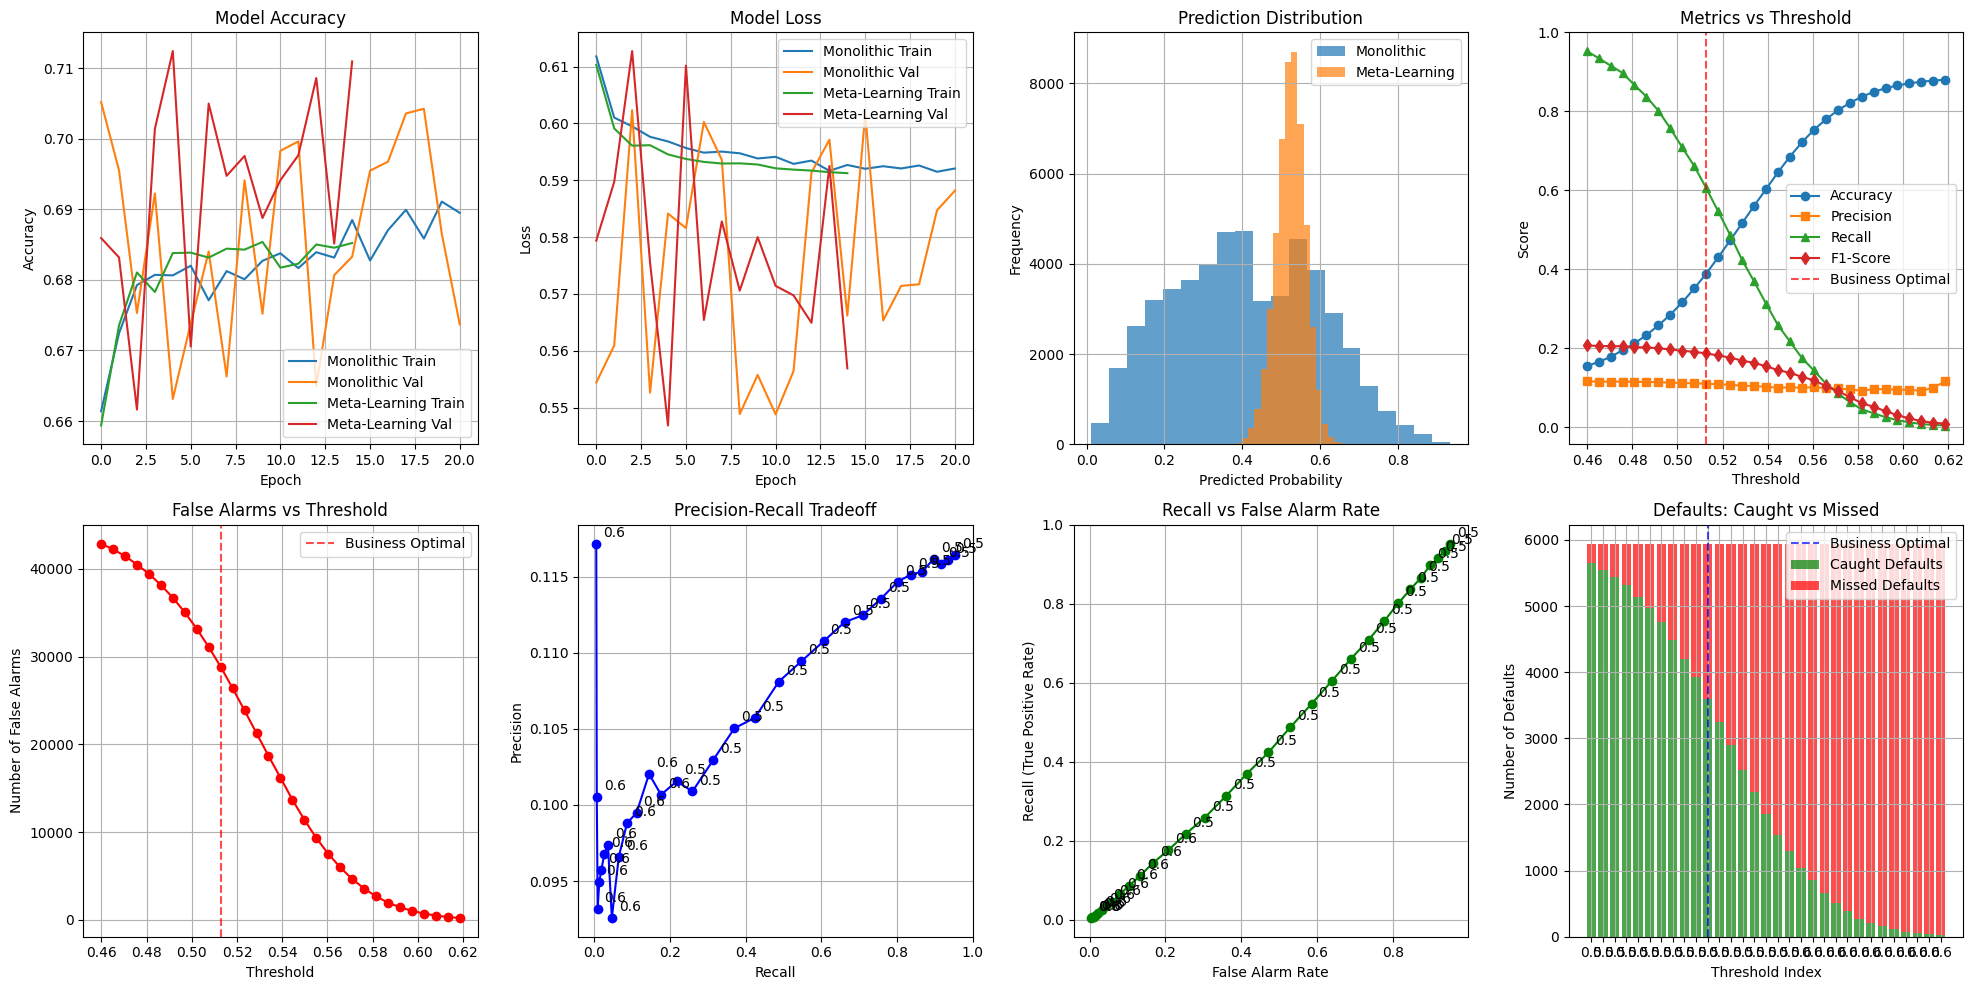

In [10]:
if __name__ == "__main__":
    # Update this path to your CSV file
    file_path = "/Users/peekay/Downloads/Loan_default.csv"  # Change this to your actual file path.  Download from here: https://www.kaggle.com/datasets/nikhil1e9/loan-default/data
    results = train_and_evaluate_models(file_path)